# Regression Analysis on Evictions, Poverty, and Race
In the "enhancing-statistical-rigor" notebook it became clear that the EL mislabeled the flag columns:
- imputed -- was accidentally labeled --> low-flag
- subbed -- was accidentally labeled --> imputed
- low-flag -- was accidentally labeled --> subbed.

So, I'll fix the labels and then compare regression analyses on:
- all the data
- filtered data (i.e. drop the data points that have been flagged as low)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [2]:
import plotly.figure_factory as ff

In [618]:
import re

In [3]:
sns.set(style = 'darkgrid')

## - Read in the County Level Data and correct the labels

In [4]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)
counties_evicts_df.head()

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,imputed,subbed,low-flag
0,47001,2000,Anderson County,Tennessee,71330.0,13.14,27.49,450.0,35483.0,87500.0,...,1.14,0.07,8189.0,125.0,118.0,1.44,1.53,0,0,1
1,47003,2000,Bedford County,Tennessee,37586.0,13.14,26.46,488.0,36729.0,79000.0,...,0.77,0.05,3679.0,104.0,98.0,2.66,2.83,0,0,0
2,47005,2000,Benton County,Tennessee,16537.0,15.63,19.47,367.0,28679.0,67000.0,...,0.62,0.03,1336.0,17.0,17.0,1.27,1.27,0,0,0
3,47007,2000,Bledsoe County,Tennessee,12367.0,18.07,18.24,343.0,28982.0,67200.0,...,1.03,0.02,808.0,0.0,0.0,0.00,0.00,0,0,0
4,47009,2000,Blount County,Tennessee,105823.0,9.73,24.11,450.0,37862.0,103900.0,...,0.88,0.05,10286.0,210.0,201.0,1.95,2.04,0,0,1


Confirm my 'low-flag' column corroborates the criteria stated in pg. 40 of the methodology report
- *i.e. that at least 25% of the counties between 2009 - 2016 are flagged as low*
    - that's from January 1st 2009 - January 1st 2016

In [5]:
cty_09_15_index = [year in range(2009, 2016) for year in counties_evicts_df.year]
print('LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:') 
print("---------------------------------")
print('Years in range(2009, 2016)=', list(range(2009, 2016)))
print("")
print('Fraction of TN counties labeled as low:', counties_evicts_df[cty_09_15_index]['low-flag'].sum()/len(counties_evicts_df[cty_09_15_index]))
      

LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:
---------------------------------
Years in range(2009, 2016)= [2009, 2010, 2011, 2012, 2013, 2014, 2015]

Fraction of TN counties labeled as low: 0.24661654135338346


## - Pre-process the data for visualization and regression analysis
- pivot the counties for time series analysis

In [6]:
pivoted_counties = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'poverty-rate')
pivoted_counties.head()

name,Anderson County,Bedford County,Benton County,Bledsoe County,Blount County,Bradley County,Campbell County,Cannon County,Carroll County,Carter County,...,Unicoi County,Union County,Van Buren County,Warren County,Washington County,Wayne County,Weakley County,White County,Williamson County,Wilson County
year,,,,,,,,,,,,,,,,,,,,,
2000,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2001,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2002,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2003,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2004,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66


In [7]:
layout = go.Layout(
    autosize = True,
    #rangeslider = True,
    #width = 1600, 
    height = 800)

pivoted_counties.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## - Visualizing flagged data in the eviction rate time series for all counties
can recycle this routine for other variable time-series

In [8]:
pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= ['eviction-rate', 'low-flag'])

In [9]:
pvt_cnty_evic_rates.head(2)


eviction-rate                                              \
name Anderson County Bedford County Benton County Bledsoe County   
year                                                               
2000            1.44           2.66          1.27            0.0   
2001            2.02           2.89          2.21            0.0   

                                                                 \
name Blount County Bradley County Campbell County Cannon County   
year                                                              
2000          1.95            NaN            1.75          0.47   
2001          2.37           2.12            1.94          0.09   

                                       ...           low-flag               \
name Carroll County Carter County      ...      Unicoi County Union County   
year                                   ...                                   
2000           1.13           NaN      ...                1.0          0.0   
2001           1.19          2.38      ...                0.0          0.0   

                                                                    \
name Van Buren County Warren County Washington County Wayne County   
year                                                                 
2000              0.0           0.0               0.0          1.0   
2001              0.0           0.0               1.0          0.0   

                                                                  
name Weakley County White County Williamson County Wilson County  
year                                                              
2000            0.0          0.0               1.0           0.0  
2001            0.0          0.0               1.0           0.0  

[2 rows x 190 columns]

In [10]:
def mutate_traces_by_flag(df):
    '''Takes a timeseries df with two column levels and
    splits columns in one level according to values in the second level.
    It transfers the values from the first level to the second level; overwriting the second level.
    Returns the mutated df (with two levels)'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    dfo = df.copy(deep = True)
    # for each col in lv0
    for col in dfo[lv0].columns:
        # for each year in that column
        for year in dfo.index:
            # if variable is flagged
            if dfo[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[lv1][col][year] = dfo[lv0][col][year]
                # replace that value with None
                dfo[lv0][col][year] = None
            else:
                dfo[lv1][col][year] == None
                
    return dfo

In [11]:
def split_trace_by_flag(df, verbose = False):
    '''Takes a timeseries df with two column levels and 
    splits each column from first level into two columns according to whether or not 
    that cell has been flagged in the other level.
    Returns a one level df with twice as many columns'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    # initialize copy of df to work on
    dfo = df[lv0].copy(deep = True)
    
    # for each col in dfo
    for col in dfo.columns:
        # initialize a flag column
        fcol = str(col)+' flagged'
        if verbose:
            print(fcol)
        dfo[fcol] = None
        # for each year in that column
        for year in dfo.index:
            if verbose:
                print(year)
            # if variable is flagged
            if df[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[fcol][year] = df[lv0][col][year]
                # replace that value with None
                #dfo[col][year] = None
                
    return dfo

In [12]:
split_cnty_evic_rates = split_trace_by_flag(pvt_cnty_evic_rates)

In [13]:
split_cnty_evic_rates.sort_index(axis = 1, inplace=True)

In [14]:
split_cnty_evic_rates.head(2)

name,Anderson County,Anderson County flagged,Bedford County,Bedford County flagged,Benton County,Benton County flagged,Bledsoe County,Bledsoe County flagged,Blount County,Blount County flagged,...,Wayne County,Wayne County flagged,Weakley County,Weakley County flagged,White County,White County flagged,Williamson County,Williamson County flagged,Wilson County,Wilson County flagged
year,,,,,,,,,,,,,,,,,,,,,
2000,1.44,1.44,2.66,None,1.27,None,0.0,None,1.95,1.95,...,0.29,0.29,1.40,None,NaN,None,1.65,1.65,2.61,None
2001,2.02,2.02,2.89,None,2.21,None,0.0,None,2.37,2.37,...,0.87,None,1.52,None,NaN,None,1.53,1.53,2.95,None


In [15]:
split_cnty_evic_rates.iplot(filename='pivoted-tn-county-eviction-rate-timeseries', sharing = 'public',
                       #width = 1, dash = 'line', mode = 'lines',
                          mode = 'marker',
                            
                      title = 'TN Counties Eviction Rates, 2000 - 2016', yTitle = '%', xTitle = 'Year',
                      rangeslider = False, 
                       )

Let's try to just add a trace of red markers over the flagged values

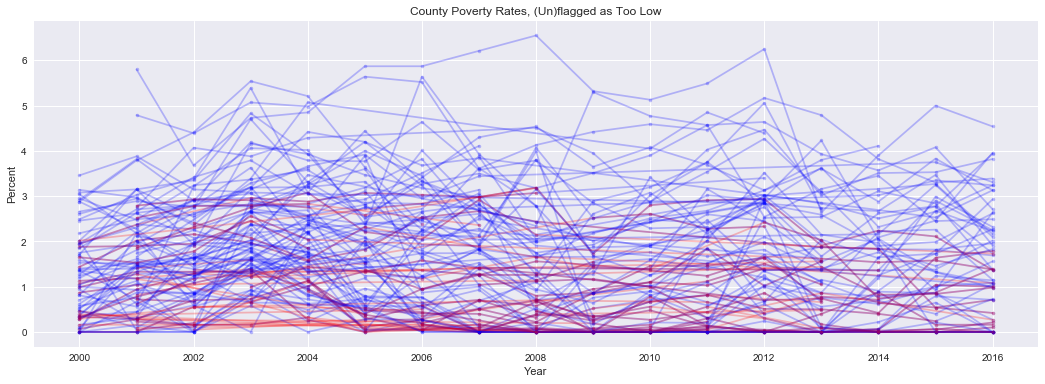

In [16]:
for col in split_cnty_evic_rates:
    if 'flagged' not in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'blue', alpha = .25, marker = '.')
        except:
            continue
    if 'flagged' in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'red', alpha = .25, marker = '.')
        except:
            continue

#plt.figure(figsize=(18, 6))
plt.title('County Poverty Rates, (Un)flagged as Too Low')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show()

To achieve this in Plotly I'll have to make two traces for every county, then I'll have to plot all 190 ish traces specifying the color of each trace. 

pseudo-code:

initialize 190ish variables

for each county assign a scatter graph object to it's two corresponding variables
append the trace to the data to be ploted by plotly. 

## - Compare flagged and unflagged eviction data

In [18]:
poverty_trace = go.Box(
    y = counties_evicts_df['poverty-rate'],
    x = counties_evicts_df.year,
    name = 'TN Poverty Rates',
    opacity = 0.25,
    marker = dict(color = 'black', opacity = 0.25, symbol = 'square')
)
bonafide_eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0],
    name = 'TN Bonafide Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'red', opacity = 0.5, symbol = 'square')
)
flagged_poverty_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 1],
    name = 'TN Low-Flagged Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'pink', opacity = 0.5, symbol = 'square')
)

eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'],
    x = counties_evicts_df.year,
    name = 'TN Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'blue', opacity = 0.5, symbol = 'square')
)

data = [poverty_trace, eviction_trace, flagged_poverty_trace, bonafide_eviction_trace]

layout = go.Layout(
    title = 'TN Poveryt, Eviction, & Filing Rates (Boxplot Timeseries)',
    yaxis = dict(title = 'Percent'),
    xaxis = dict(title = 'Year'),
    boxmode = 'group'
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

It's clear that once we filter out the rows that have been flagged as low we have a significant increase in the "center" of our distributions. 
- the median on the filtered data looks to be about .5% higher

Unfortunately the boxplot is actually obscuring how dense the distribution of values is. Let's try it again with some violin plots.

In [20]:
fig = ff.create_violin(counties_evicts_df.dropna(), data_header = 'eviction-rate', group_header = 'year', 
                       height = 500, width = 800)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

⚠️ this doesn't look right. Maybe my dropna call removed entire rows instead of just cells. 
- Also it seems like I actually have a figure for every violin, which makes it akward to try and use the tools (like zooming and panning)

## - Compare regression plots of filtered and unflitered data

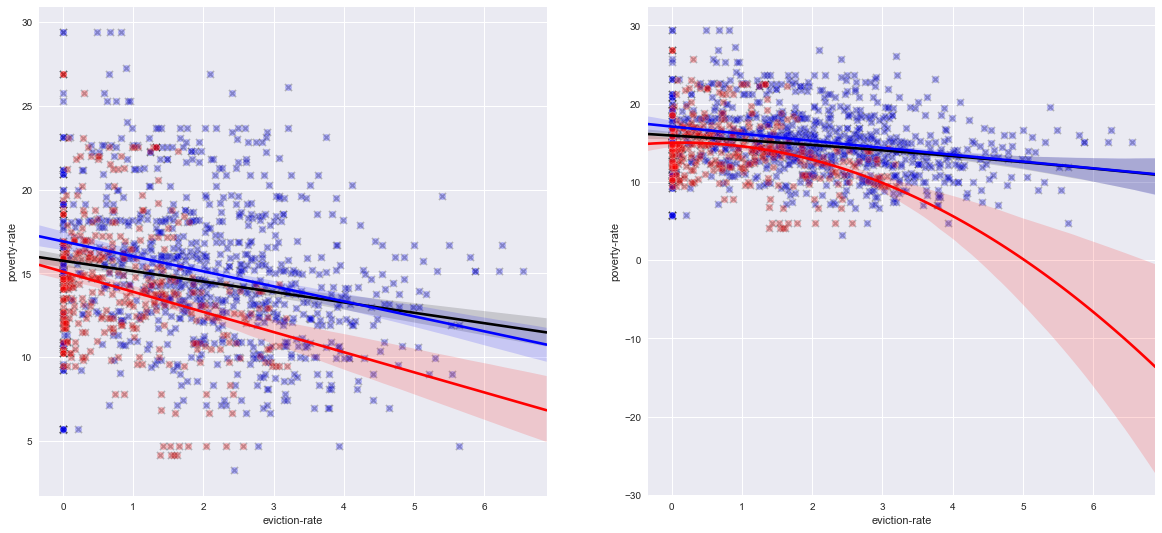

In [161]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            robust = True,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
# add filtered regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
# add low-flagged regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)

sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            order = 2, robust = False,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            order = 2, robust = False,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)

sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = False, order = 2,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
plt.show()

**Initial Observations:**
- the filtered data seems to display a slightly steeper slope i.e. a slightly stronger negative correlation.
- Also the confidence intervals are better for the first order liner regression

# Let's facet out this analysis by year

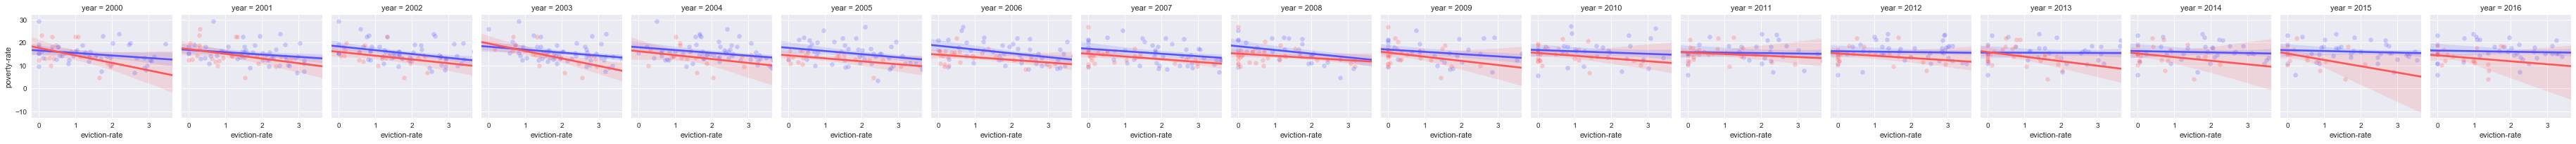

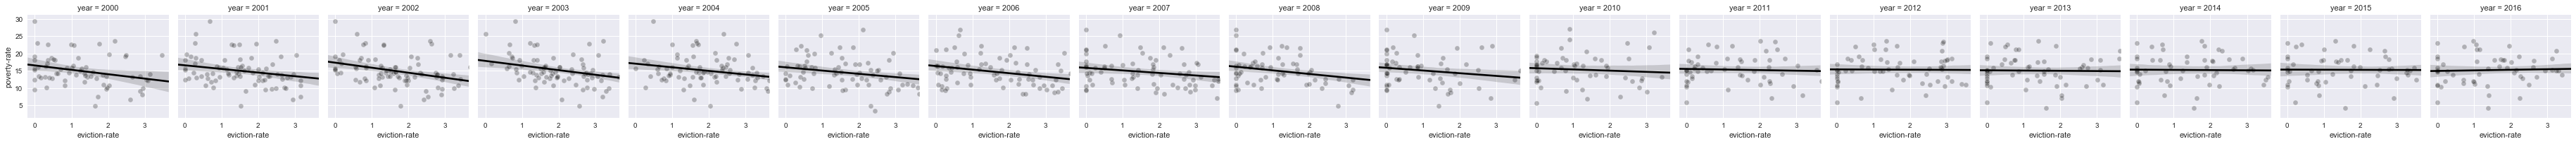

In [179]:
g = sns.FacetGrid(counties_evicts_df, col = 'year', #col_wrap = 9,
                  hue = 'low-flag', palette = 'seismic')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          #color = 'black', 
          scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

g = sns.FacetGrid(counties_evicts_df, col = 'year')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          color = 'black', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

### Initial Observations:
- **looks like the correlation got leveled off sharply after 2009. Which is interesting. The housing crisis seems to have "broken" the relationship between evictions and poverty.** 

# Compare regression plots of bonafide vs low-flagged Data

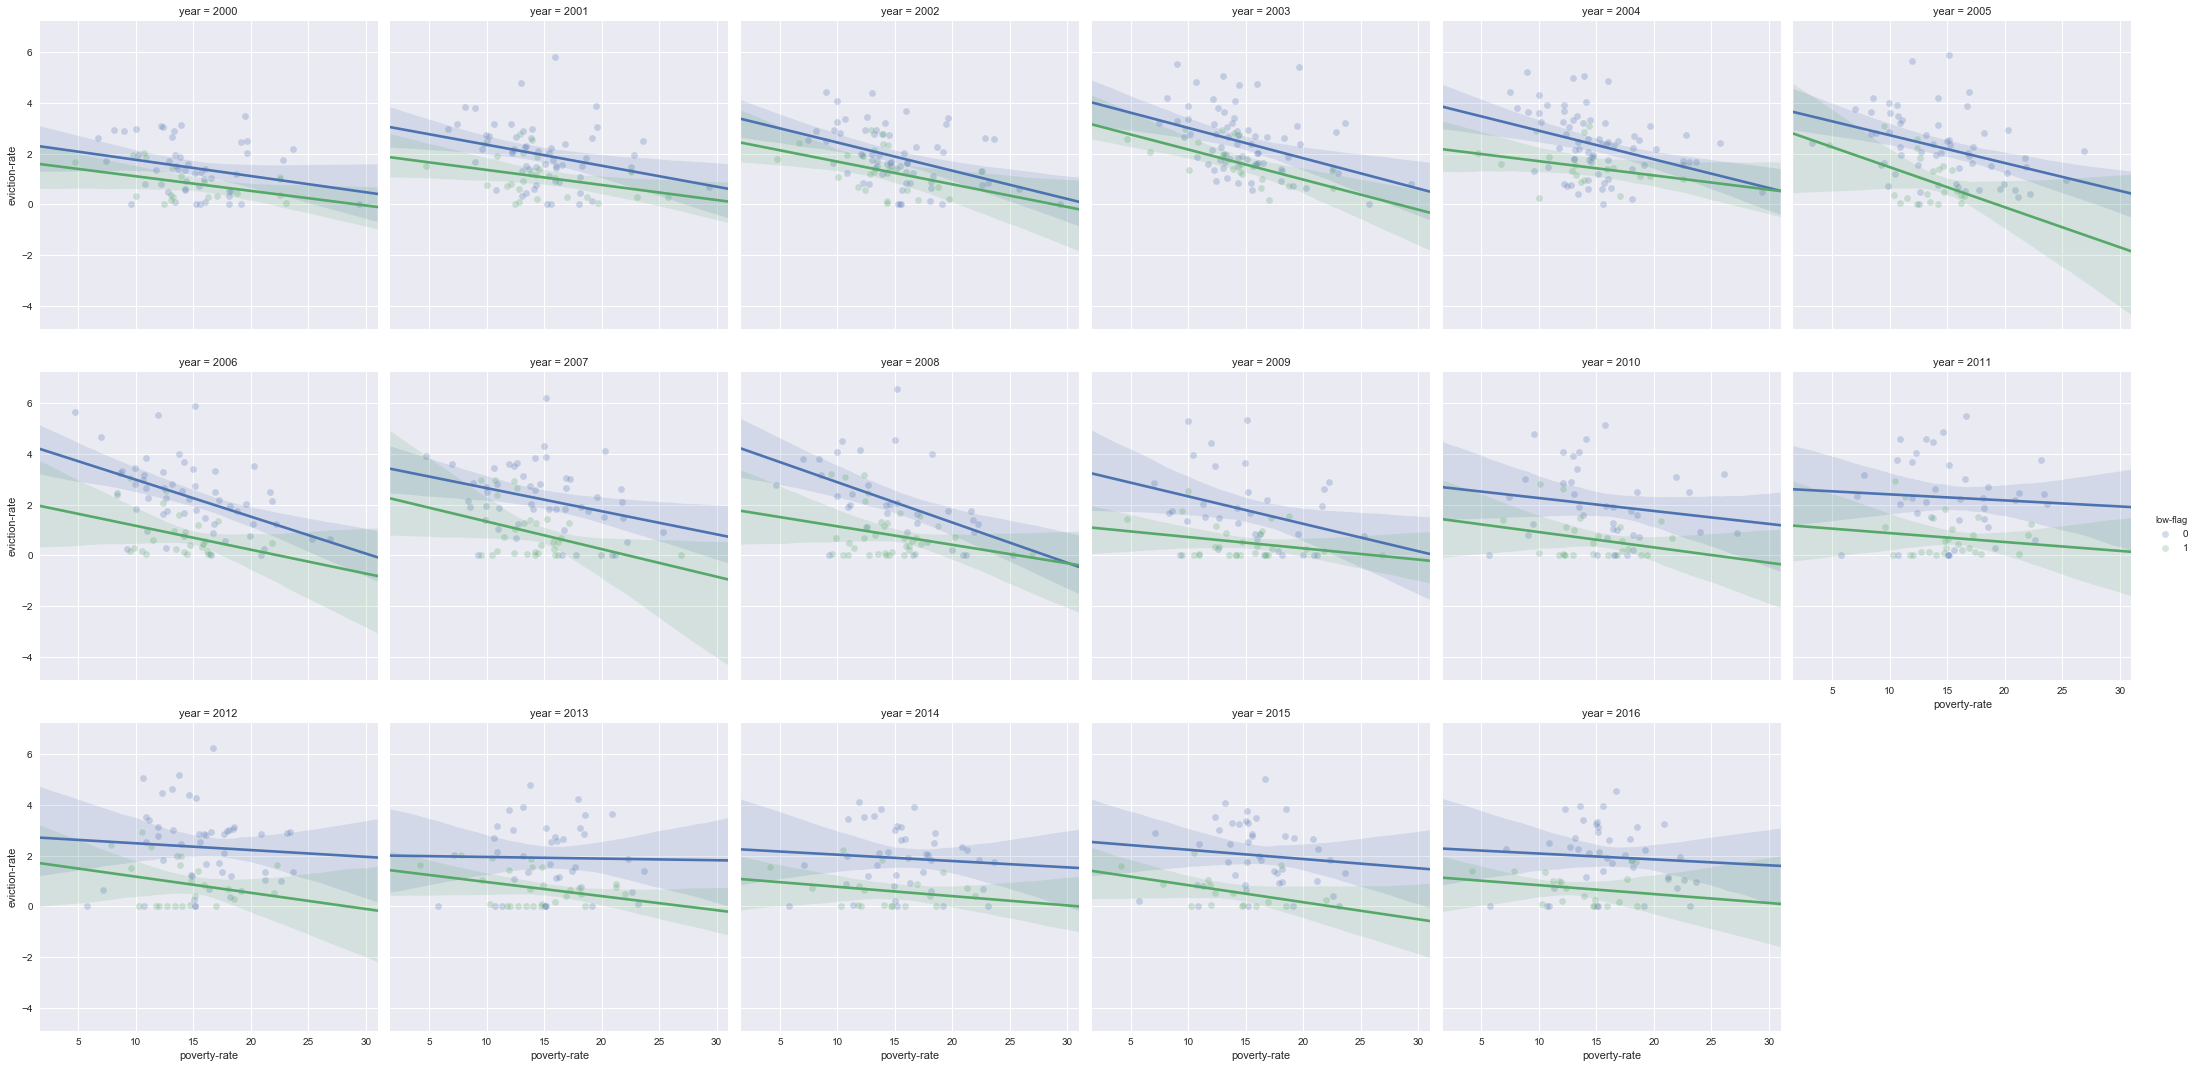

In [153]:
sns.lmplot(x = 'poverty-rate',
           y = 'eviction-rate',
           hue = 'low-flag',
           col = 'year', col_wrap = 6,
           data = counties_evicts_df,
           scatter_kws = {'alpha':'.25', 
                          'edgecolors':'white',
                          'linewidths':'.5'})
plt.show()

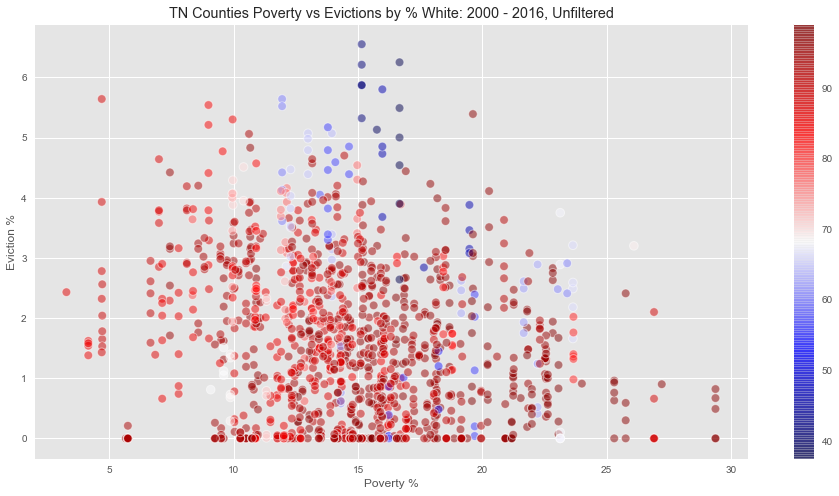

In [681]:
plt.figure(figsize=(16,8))
plt.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016, Unfiltered')
plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
cbar = plt.colorbar()
plt.show()

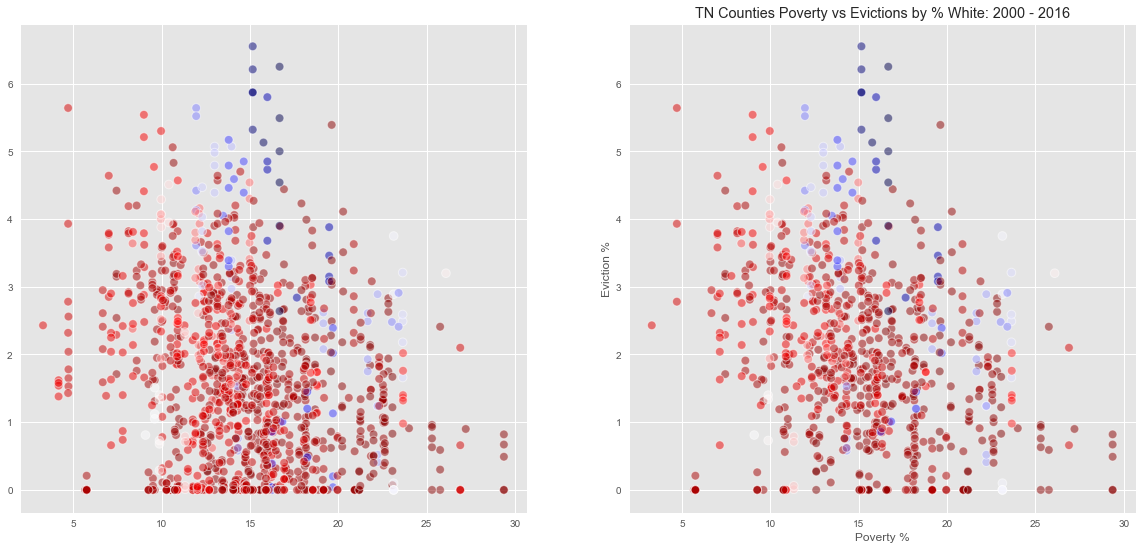

In [685]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

ax1.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')

ax2.scatter(x = 'poverty-rate', y = 'eviction-rate', 
            data = counties_evicts_df[counties_evicts_df['low-flag'] == 0], 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')

plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016')
#cbar = f.colorbar(mappable = c, ax=ax1)
#cbar = plt.colorbar()
plt.show()

**This is interesting, when comparing it to the unfiltered data the distribution looks significantly "thinned out." However, at first blush it seems as if we have filtered out many more "whiter" counties than "non-white" counties.**

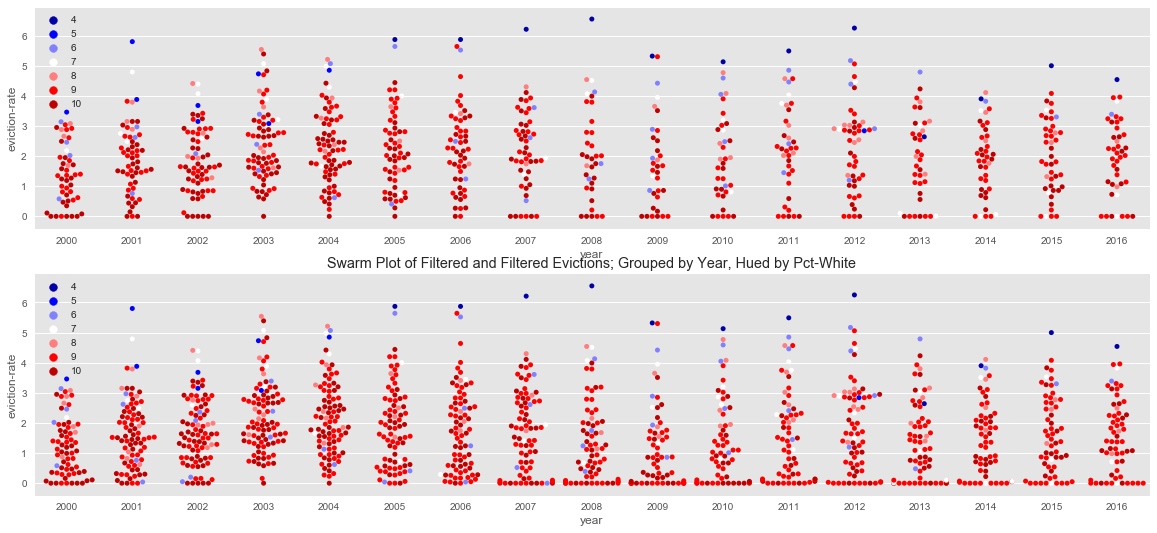

In [679]:
#plt.figure(figsize=(18,6))
f, (ax1, ax2) = plt.subplots(2, 1, sharey = False, figsize = (20, 9))


sns.swarmplot(x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0], 
                   y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic',
                  ax = ax1)
plt.title('Swarm Plot of Filtered and Filtered Evictions; Grouped by Year, Hued by Pct-White')


sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-rate'], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic',
                  ax = ax2)
plt.show()

# Look at correlation matrix of the data
Which variables are suitable for correlation measurements?
- Do I need to adjust anything from the scales?

In [115]:
corr = counties_evicts_df[[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [686]:
corr.head(3)

,population,renter-occupied-households,evictions,eviction-filings,median-gross-rent,median-household-income,median-property-value,poverty-rate,pct-renter-occupied,rent-burden,pct-white,pct-af-am,pct-hispanic,eviction-rate,eviction-filing-rate
population,1.000000,0.986363,0.947501,0.913979,0.431808,0.347254,0.357792,-0.208889,0.508642,0.136886,-0.528802,0.467912,0.312423,0.520225,0.838343
renter-occupied-households,0.986363,1.000000,0.959308,0.918307,0.386603,0.271319,0.289854,-0.147021,0.539659,0.140109,-0.537473,0.475853,0.320560,0.492939,0.818223
evictions,0.947501,0.959308,1.000000,0.950431,0.372498,0.237366,0.261364,-0.089584,0.524560,0.165361,-0.606146,0.552686,0.410187,0.516409,0.826302


In [117]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

## Let's compare this to the correlation matrix of the filtered data
(i.e. where we drop all the rows that were flagged as having eviction data that was "too low.")

In [119]:
corr_filtered = counties_evicts_df[counties_evicts_df['low-flag'] == 0][[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [120]:
mask_filtered = np.zeros_like(corr_filtered, dtype = np.bool)
mask_filtered[np.triu_indices_from(mask_filtered)] = True

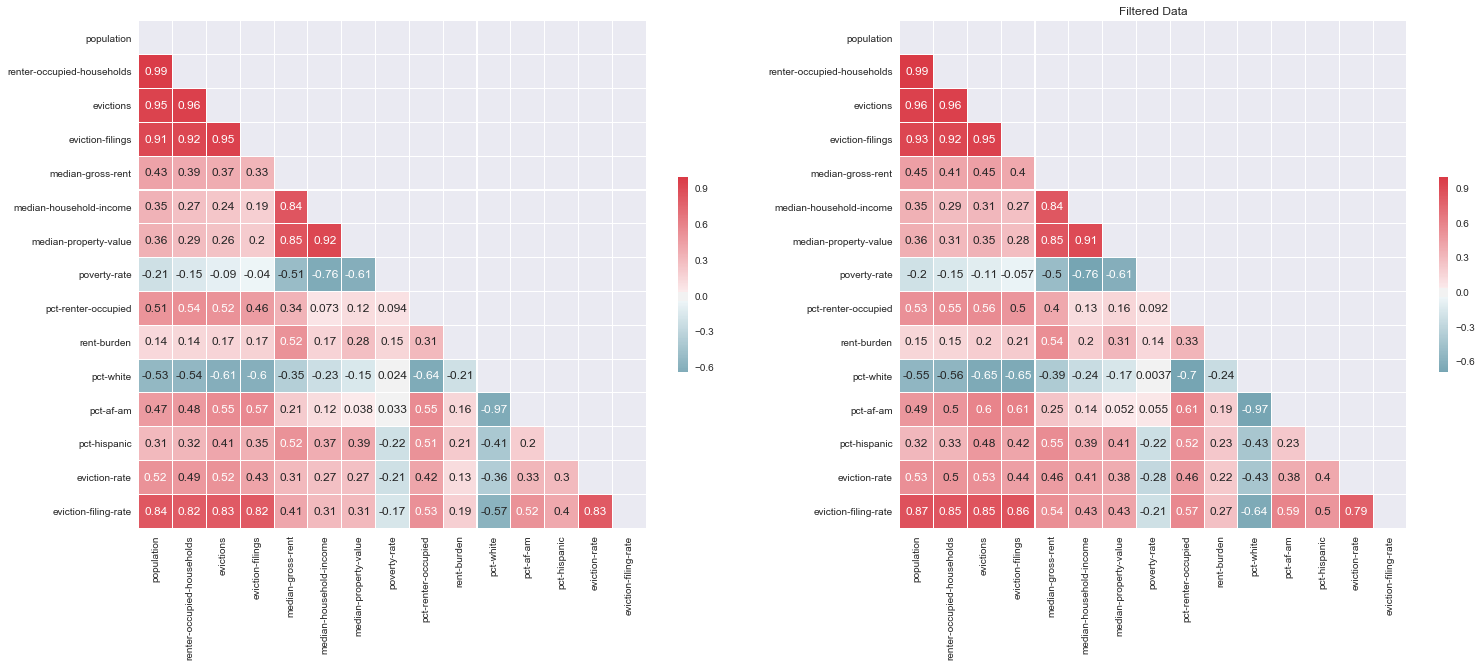

In [134]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (25,12) )

# plot the unfiltered correlation matrix heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, cbar = True,
            robust = True,
           center = 0, square = True, linewidth = 0.1, 
            cbar_kws = {'shrink': 0.3}, 
            ax = ax1)

# plot the filtered correlation matrix heatmap
sns.heatmap(corr_filtered, mask = mask_filtered, cmap = cmap, annot = True,
           robust = True, center = 0, square = True, linewidth = 0.05,
           cbar_kws = {'shrink' : 0.3},
            ax = ax2)
plt.title('Filtered Data')
plt.show()

## That's interesting!
### poverty-rate
#### - is negatively correlated to everything except:
- 0.15, rent-burden, a weak correlation that makes sense
- 0.094, pct-renter-occupied
    - **actually, this is interesting** It suggests that whether there are or are not a lot of renters in your county does not impact whether or not there is poverty in your county. 
- **0.024, pct-white, the lowest of all the correlation coefficients** showing that a county being whiter has virtually no impact on poverty
#### - is interestingly weakly negatively correlated to:
- -0.21 eviction rate: suggesting gentrification? Or the ejection or displacement of people in poverty?
    - Where are these people ending up?
- -0.17 eviction filing rate, suggesting that pressuring 
#### - is strongly negatively (and unsurprisingly) correlated to
- measures of a countie's wealth:
    - 0.76, median-household-income
    - 0.61, median-property-value
    - 0.51, median-gross-rent

# -------------------------------------

# Correlation of Evictions/Filings to Poverty in General
1. At a national level, how do evictions, filings, and poverty correlate?
    - hold off until I get the national traces
2. At the state level, how do evictions, filings, and poverty correlate?
- 
- What is the time series like?
    - see the EDA notebook
- What does the map look like?
    - would like a topographical map showing net gains or falls in each metric
    - heatmap for evictions
        - could also do labels, (e, f) = (+1, +2)
    - topography for poverty?

## 2.1 At the State Level, How do Evictions, Filings, and Poverty correlate in TN?

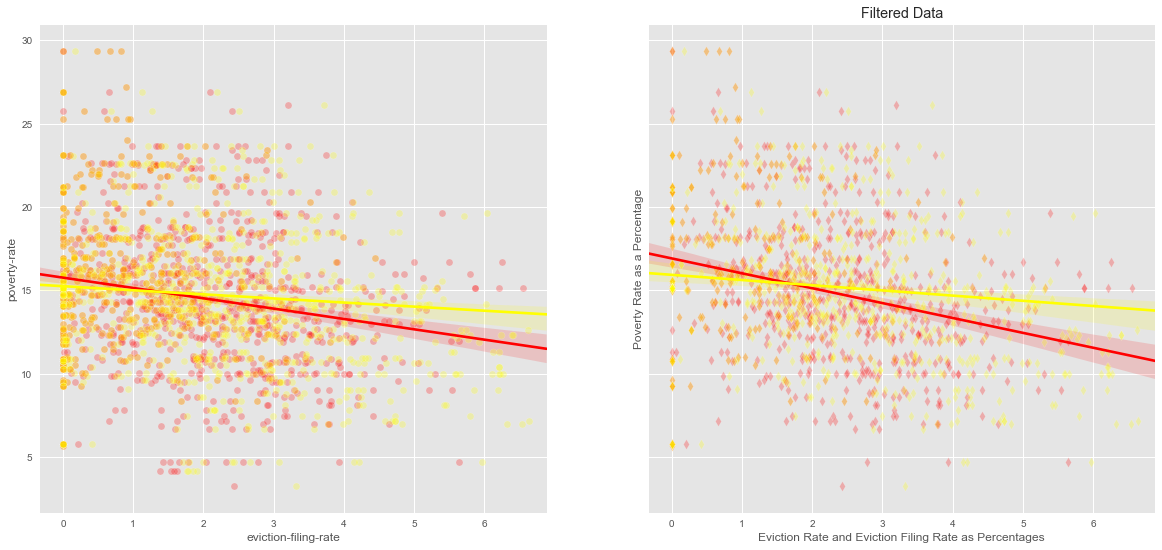

In [687]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
sns.regplot(x = counties_evicts_df['eviction-filing-rate'],
           y = counties_evicts_df['poverty-rate'],
           robust = True,
           color = 'yellow', marker = 'o', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax1)
plt.title('Unfiltered Data')
plt.xlabel('Eviction Rate and Eviction Filing Rate as Percentages')
plt.ylabel('Poverty Rate as a Percentage')

# add filtered regression to axis 2
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'red', marker = 'd', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(x = counties_evicts_df['eviction-filing-rate'][counties_evicts_df['low-flag'] == 0],
           y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           robust = True,
           color = 'yellow', marker = 'd', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax2)

plt.title('Filtered Data')
plt.xlabel('Eviction Rate and Eviction Filing Rate as Percentages')
plt.ylabel('Poverty Rate as a Percentage')

plt.show()

**But the above regression combines yearly vs periodically collected data.** Such that between censuses the poverty data is portrayed comepletely insensitive to changes in anual metrics. 
### How do these correlations change when we only use years where both metrics were measured?
i.e. 2000, 2005, 2010, 2011

In [232]:
census_years = [y in [2000, 2005, 2010, 2011] for y in counties_evicts_df['year']]

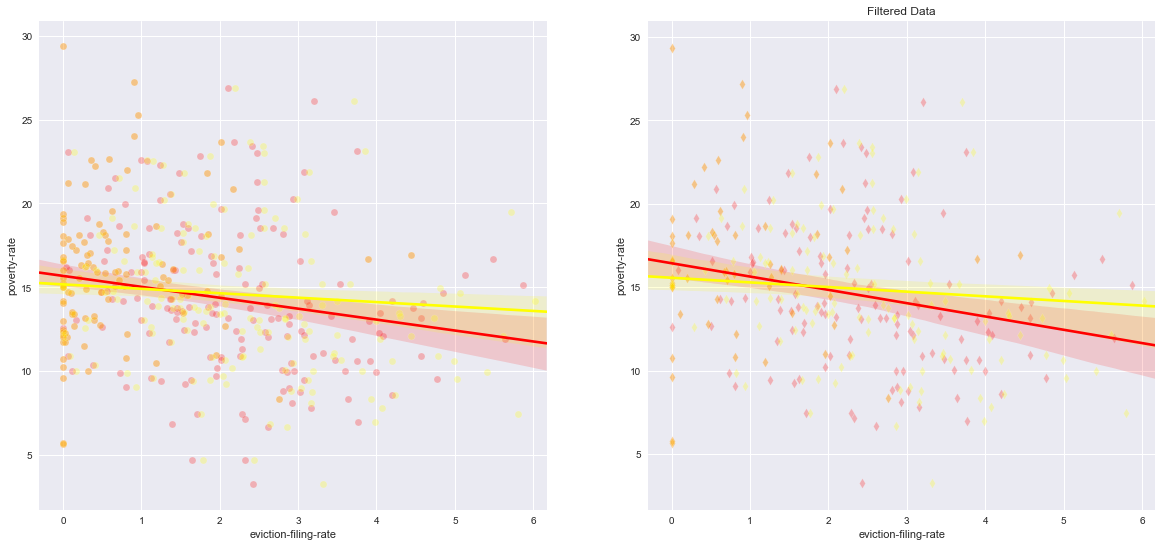

In [234]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df[census_years]['poverty-rate'],
           x = counties_evicts_df[census_years]['eviction-rate'],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
sns.regplot(x = counties_evicts_df[census_years]['eviction-filing-rate'],
           y = counties_evicts_df[census_years]['poverty-rate'],
           robust = True,
           color = 'yellow', marker = 'o', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax1)
# add filtered regression to axis 2
sns.regplot(y = counties_evicts_df[census_years]['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df[census_years]['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'red', marker = 'd', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(x = counties_evicts_df[census_years]['eviction-filing-rate'][counties_evicts_df['low-flag'] == 0],
           y = counties_evicts_df[census_years]['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           robust = True,
           color = 'yellow', marker = 'd', scatter_kws = {'alpha': '.25',
                                                         'edgecolors': 'white',
                                                         'linewidths': '.5'},
            line_kws = {'linestyle':'-'}, 
           ax = ax2)
plt.title('Filtered Data')

plt.show()

##### Hmmm.... Looks about the same. I guess there was no need to plot it, especially since my eyes can't judge the coefficient with sufficient accuracy. 
### Compare correlation coefficients in general vs census years:


In [689]:
print('Correlation Coefficient During Census Years:')
print(np.corrcoef(x = counties_evicts_df[census_years].dropna()['eviction-rate'],
           y = counties_evicts_df[census_years].dropna()['poverty-rate'])[0][1])
print("")
print('Correlation Coefficient Across all Years:')
print(np.corrcoef(x = counties_evicts_df.dropna()['eviction-rate'],
           y = counties_evicts_df.dropna()['poverty-rate'])[0][1])
print('')

Correlation Coefficient During Census Years:
-0.1952692614777052

Correlation Coefficient Across all Years:
-0.20680714792812885



### Looks like the correlation is negligibly weaker in census years

## 3.1 Which Counties had the strongest and weakest correlation coefficients between evictions, filings and poverty?
- A. We can measure this correlation for the 16 years of each county
- B. We can get much more granular by using the census tracts within each county

In [516]:
county_correlations_df.columns

Index(['county', 'pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
       'tract-pov-filing-corr'],
      dtype='object')

In [517]:
county_correlations_df = pd.DataFrame(data = list(set(counties_evicts_df.name)), 
                                      index=range(len(set(counties_evicts_df.name))),
                                     columns = ['county'])

county_correlations_df['pov-evic-corr'] = np.nan
county_correlations_df['tract-pov-evic-corr'] = np.nan
county_correlations_df['pov-filing-corr'] = np.nan
county_correlations_df['tract-pov-filing-corr'] = np.nan
#county_correlations_df[['pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
#       'tract-pov-filing-corr']] = 
county_correlations_df.head(3)


,county,pov-evic-corr,tract-pov-evic-corr,pov-filing-corr,tract-pov-filing-corr
0,Overton County,NaN,NaN,NaN,NaN
1,Montgomery County,NaN,NaN,NaN,NaN
2,Moore County,NaN,NaN,NaN,NaN


In [305]:
census_tracts_df = pd.read_csv('data/tracts.csv')
census_tracts_df.head(3)

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,47001020100,2000,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,831.0,16.0,13.0,1.56,1.93,0,0,1
1,47001020100,2001,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,864.0,16.0,13.0,1.51,1.85,0,0,1
2,47001020100,2002,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,896.0,12.0,10.0,1.12,1.34,0,0,1
3,47001020100,2003,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,929.0,13.0,11.0,1.18,1.40,0,0,1
4,47001020100,2004,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,961.0,22.0,10.0,1.04,2.29,0,0,1


In [617]:
for cty in set(census_tracts_df['parent-location']):
    if 'Tennessee' not in cty:
        print(cty)
        print('-', re.sub(',.*', '', cty))
        print('--', re.sub(',.*', '', cty) in list(set(counties_evicts_df.name)))
        print("")

Allen County, Kentucky
- Allen County
-- False

Fannin County, Georgia
- Fannin County
-- False

Mississippi County, Arkansas
- Mississippi County
-- False

Todd County, Kentucky
- Todd County
-- False

Haywood County, North Carolina
- Haywood County
-- True



In [ ]:
# drop all of these rows from census_tracts_df

In [624]:
census_tracts_df = census_tracts_df[['Tennessee' in cty for cty in census_tracts_df['parent-location']]]

In [647]:
tally = 0
for cty in set(census_tracts_df['parent-location']):
    if 'Tennessee' not in cty:
        print(cty)
        print('-', re.sub(',.*', '', cty))
        print('--', re.sub(',.*', '', cty) in list(set(counties_evicts_df.name)))
        print("")
        tally =+ 1
if tally == 0:
    print('Good to go, successfully removed all non-tn counties.')

Good to go, successfully removed all non-tn counties.


In [627]:
# assert that I can match the county names with parent-locations using some python magic
for name in counties_evicts_df.name.unique():
    assert str(name + ', Tennessee') in list(set(census_tracts_df['parent-location']))

In [628]:
round(np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['poverty-rate']
    )[0][1], 4)

-0.271

In [629]:
type(np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == 'Davidson County'].dropna()['poverty-rate']
    )[0][1])

numpy.float64

In [630]:
for i, county in zip(range(len(county_correlations_df.county)), county_correlations_df.county):
    #print(county)
    county_correlations_df['pov-evic-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-evic-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['pov-filing-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-filing-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-filing-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning:

Mean of empty slice.

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning:

invalid value encountered in true_divide

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning:

invalid value 

In [631]:
county_correlations_df.head()

,county,pov-evic-corr,tract-pov-evic-corr,pov-filing-corr,tract-pov-filing-corr,filtered-pec,filtered-tpec,filtered-pfc,filtered-tpfc
0,Overton County,0.199562,-0.220604,0.067074,-0.193783,NaN,NaN,NaN,NaN
1,Montgomery County,-0.216227,-0.017844,0.461114,-0.009508,NaN,NaN,NaN,NaN
2,Moore County,0.558533,0.279910,0.546522,0.279910,NaN,NaN,NaN,NaN
3,Macon County,-0.584097,0.238722,-0.599422,0.224537,NaN,NaN,NaN,NaN
4,Hawkins County,-0.146741,0.022558,-0.102303,0.157195,NaN,NaN,NaN,NaN


In [632]:
county_correlations_df.sort_values(by = 'pov-evic-corr').head()

,county,pov-evic-corr,tract-pov-evic-corr,pov-filing-corr,tract-pov-filing-corr,filtered-pec,filtered-tpec,filtered-pfc,filtered-tpfc
51,Dickson County,-0.827029,-0.053962,-0.613073,0.003638,NaN,NaN,NaN,NaN
17,Henderson County,-0.792177,-0.236546,-0.795449,-0.239623,NaN,NaN,NaN,NaN
90,Campbell County,-0.767627,-0.257288,-0.613855,-0.213287,NaN,NaN,NaN,NaN
42,Johnson County,-0.706232,0.199821,-0.752313,0.232964,NaN,NaN,NaN,NaN
64,Meigs County,-0.674216,0.456861,-0.617822,0.422728,NaN,NaN,NaN,NaN


In [633]:
county_correlations_df.sort_values(by = 'pov-evic-corr').dropna().tail()

,county,pov-evic-corr,tract-pov-evic-corr,pov-filing-corr,tract-pov-filing-corr,filtered-pec,filtered-tpec,filtered-pfc,filtered-tpfc


### Let's look at a histogram of these correlation coefficients

Histograms of county correlation coefficients


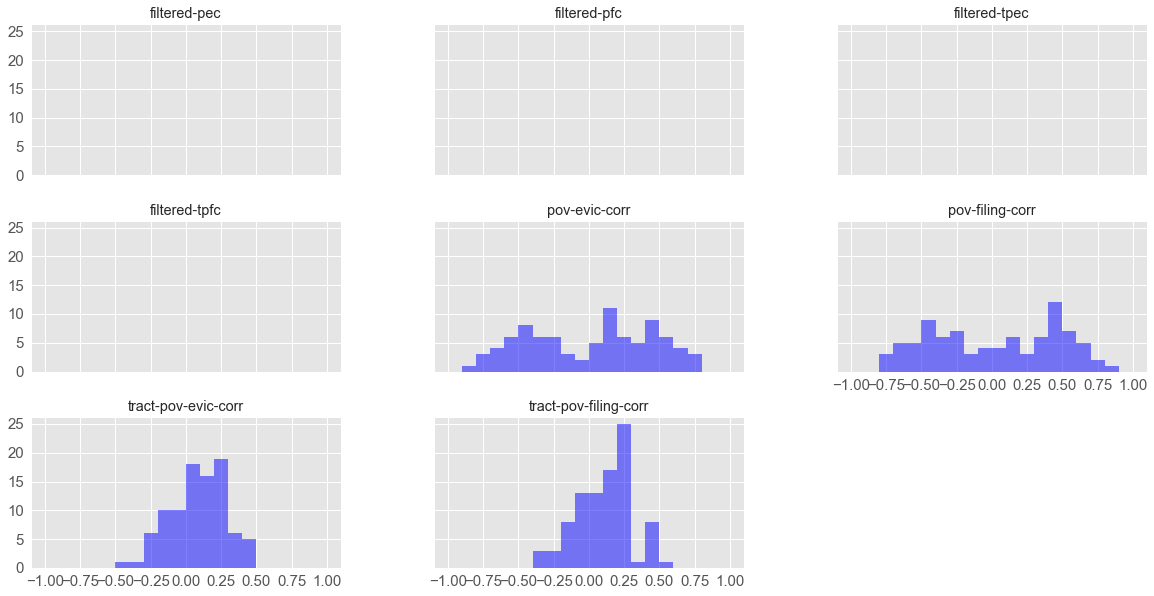

In [634]:
print('Histograms of county correlation coefficients')
county_correlations_df.hist(alpha = .5, sharex= True, sharey= True, 
                            figsize= (20, 10), xlabelsize = 15, ylabelsize = 15, 
                            range = (-1, 1), bins = 20, color = 'blue'
                           )
plt.show()

### Let's look at a histogram of the magnitudes of the correlation coefficients

Histogram of Magnitudes of Corr. Coeff.


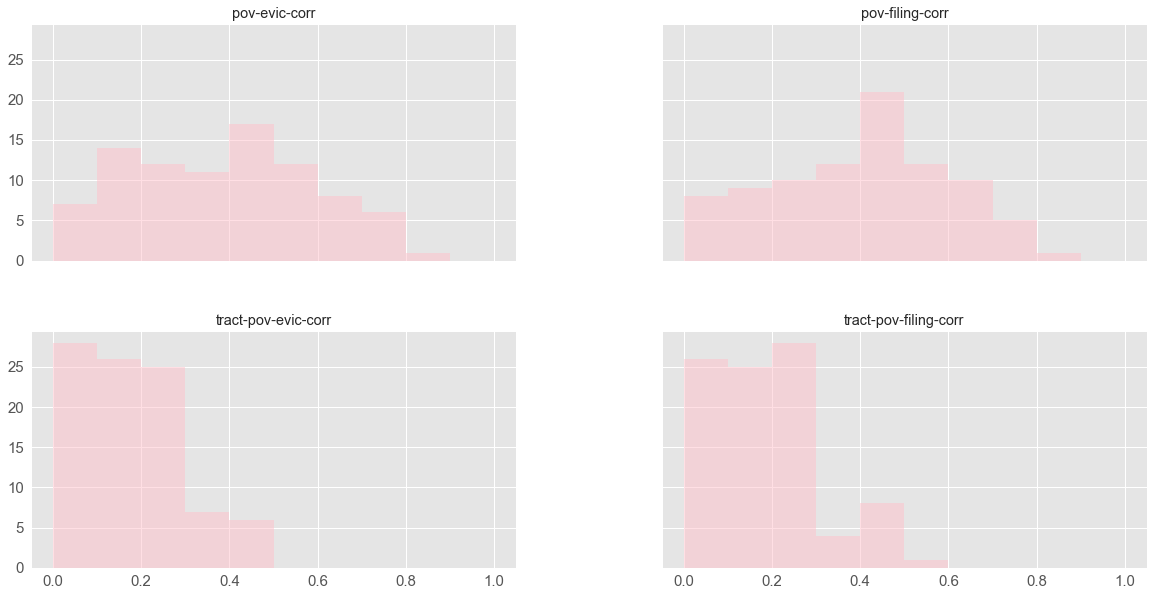

In [635]:
print('Histogram of Magnitudes of Corr. Coeff.')
county_correlations_df[['pov-evic-corr', 'tract-pov-evic-corr', 'pov-filing-corr',
       'tract-pov-filing-corr']].apply(abs).hist(alpha = .5, sharex= True, sharey= True, 
                            figsize= (20, 10), xlabelsize = 15, ylabelsize = 15, 
                            range = (0, 1), bins = 10, color = 'pink'
                           )
plt.show()

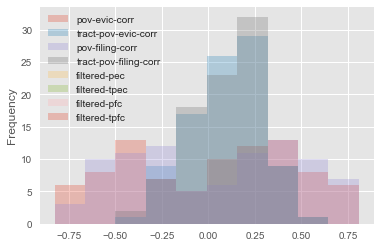

In [636]:
county_correlations_df.plot(kind = 'hist', alpha = 0.3)
plt.show()

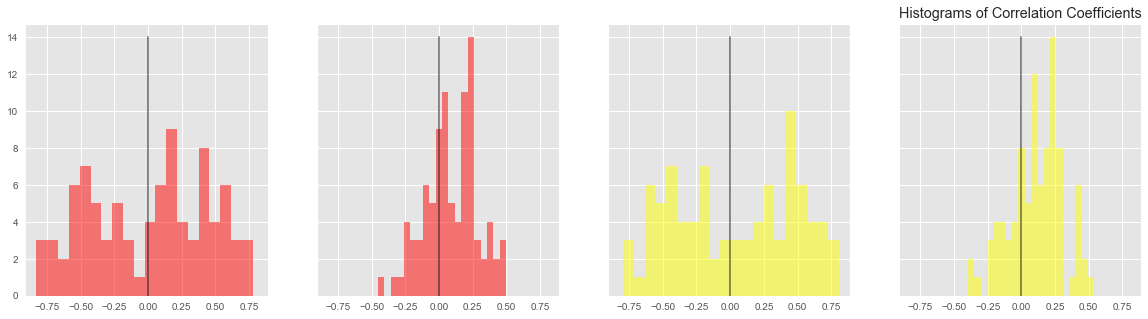

In [637]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True, sharex= True,
                                       figsize = (20, 5))
ax1.hist([v for v in county_correlations_df['pov-evic-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'red'
        )
ax1.plot([0, 0], [0, 14], 'black', alpha = 0.5)
ax2.hist([v for v in county_correlations_df['tract-pov-evic-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'red'
        )
ax2.plot([0, 0], [0, 14], 'black', alpha = 0.5)

ax3.hist([v for v in county_correlations_df['pov-filing-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'yellow'
        )
ax3.plot([0, 0], [0, 14], 'black', alpha = 0.5)

ax4.hist([v for v in county_correlations_df['tract-pov-filing-corr'].dropna()], 
         alpha = .5, bins = 20, color = 'yellow'
        )
ax4.plot([0, 0], [0, 14], 'black', alpha = 0.5)

plt.title('Histograms of Correlation Coefficients')
plt.show()

**Initial Observations**
- There are more stronger (or significant) when a county's coefficient is calculated at the county level across 16 years. 
    - there are virtually no coefficients of magnitude greater than .5 when they are calculated at the census tract level. 
    - *What might explain this?*
        - would have to look into how the census tract level data was produced
- There are a significant number of counties with coefficients of magnitude greater than .5
    - exactly how many?

### What does the distribution of coefficients look like for the filtered data?

In [638]:
county_correlations_df['filtered-pec'] = np.nan
county_correlations_df['filtered-tpec'] = np.nan
county_correlations_df['filtered-pfc'] = np.nan
county_correlations_df['filtered-tpfc'] = np.nan

Before I run the loop below to assign the values I'm going to have to fix the flags in the tracts df

In [649]:
for col in ['low-flag', 'imputed', 'subbed']:
    print(col, 'sum:', census_tracts_df[col].sum(), 'pct:', census_tracts_df[col].sum()/len(census_tracts_df))

low-flag sum: 736 pct: 0.028977518799952754
imputed sum: 0 pct: 0.0
subbed sum: 4391 pct: 0.17288082207960942


In [640]:
census_tracts_df.head()

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,47001020100,2000,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,831.0,16.0,13.0,1.56,1.93,0,0,1
1,47001020100,2001,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,864.0,16.0,13.0,1.51,1.85,0,0,1
2,47001020100,2002,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,896.0,12.0,10.0,1.12,1.34,0,0,1
3,47001020100,2003,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,929.0,13.0,11.0,1.18,1.40,0,0,1
4,47001020100,2004,201.0,"Anderson County, Tennessee",2463.0,15.14,66.67,426.61,27250.48,91901.49,...,2.31,0.2,961.0,22.0,10.0,1.04,2.29,0,0,1


In [667]:
for lc in set(census_tracts_df['parent-location'][census_tracts_df['low-flag'] == 1]):
    print(lc)
    #print('-', re.sub(', Tennessee', '', lc))
    print('--', re.sub(', Tennessee', '', lc) in set(counties_evicts_df.name[counties_evicts_df['low-flag'] == 1]))
    

Sumner County, Tennessee
-- False
Knox County, Tennessee
-- False
Henderson County, Tennessee
-- True
Hamilton County, Tennessee
-- True
Bradley County, Tennessee
-- True
Weakley County, Tennessee
-- True
Hancock County, Tennessee
-- False
Wilson County, Tennessee
-- True
Dickson County, Tennessee
-- True
Sullivan County, Tennessee
-- True
White County, Tennessee
-- False
Hawkins County, Tennessee
-- False
Rhea County, Tennessee
-- True
Anderson County, Tennessee
-- True
Franklin County, Tennessee
-- True
Gibson County, Tennessee
-- True
Putnam County, Tennessee
-- True
Dyer County, Tennessee
-- True
Carter County, Tennessee
-- False
Cocke County, Tennessee
-- True


In [668]:
for lc in set(counties_evicts_df.name[counties_evicts_df['low-flag'] == 1]):
    print(lc)
    print('-', lc in set(census_tracts_df['parent-location'][census_tracts_df['low-flag'] ==1]))

Overton County
- False
Giles County
- False
Bradley County
- False
Greene County
- False
Unicoi County
- False
Sullivan County
- False
Rutherford County
- False
Madison County
- False
Dickson County
- False
Grundy County
- False
McNairy County
- False
Marshall County
- False
Lincoln County
- False
Smith County
- False
Henry County
- False
Cannon County
- False
Blount County
- False
Claiborne County
- False
Hardin County
- False
Maury County
- False
DeKalb County
- False
Union County
- False
Benton County
- False
Dyer County
- False
Stewart County
- False
Franklin County
- False
Williamson County
- False
Weakley County
- False
Monroe County
- False
Cocke County
- False
Humphreys County
- False
Henderson County
- False
Gibson County
- False
Lawrence County
- False
Putnam County
- False
Carroll County
- False
Hamblen County
- False
Fayette County
- False
Polk County
- False
Morgan County
- False
Sequatchie County
- False
Cumberland County
- False
Rhea County
- False
Washington County
- Fa

Ok, so are these the same counties that are flagged as low in the counties df?

census_tracts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)

for i, county in zip(range(len(county_correlations_df.county)), county_correlations_df.county):
    #print(county)
    county_correlations_df['pov-evic-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-evic-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['pov-filing-corr'][i] = np.corrcoef(
        x = counties_evicts_df[counties_evicts_df.name == county].dropna()['eviction-filing-rate'],
        y = counties_evicts_df[counties_evicts_df.name == county].dropna()['poverty-rate']
    )[0][1]
    county_correlations_df['tract-pov-filing-corr'][i] = np.corrcoef(
        x = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['eviction-filing-rate'],
        y = census_tracts_df[census_tracts_df['parent-location'] == str(county + ', Tennessee')].dropna()['poverty-rate']
    )[0][1]